# Tanglegram 
Build tanglegram of Bacillus sequnces embedded with Bacillus trained Protvec Model


In [2]:
#imports 
library(dendextend) #makes tanglegram
library(factoextra) #plots single dendrogram 
library(cluster) #does the hierachical clustering
library(dplyr)
library(parallelDist) #fastest package for creating distance matrix 
library(RColorBrewer)
library(hash) #r equivalent of dictionary 

## Calculate distances between the embedded sequences

In [ ]:
#import protvec bacillus embedding 
bacil_embedding <- read.delim(file = '../Annotating_Bacterial_Function_Space_DATA/bacillus_carbohydratemetabolism_embedded.tsv', sep = '\t') #bacillus sequence trained with bacillus model 
#set the sequence md5s as the index 
rownames(bacil_embedding) <- bacil_embedding$X
bacil_embedding$X <- NULL
#standardise the embedding 
bacil_stand <- scale(bacil_embedding)

#generate a random sample of 500 sequences 
samples <- dim(bacil_stand)[1]
subset <- sample.int(samples-1,1000)
bacil_sample <- bacil_stand[subset,]

#calculate the distance matrices 
bacil_euclidean <- parDist(bacil_sample, method = 'euclidean')

In [3]:
#do the different types of clustering 
#comment out different lines if needed to reduce the memory requirements
bacil_euclid_ward <- agnes(bacil_euclidean, method = 'ward', diss = TRUE)
#bacil_euclid_diana <- diana(bacil_euclidean, diss = TRUE)

## Build Tanglegram

In [ ]:
#read in the subsystems ontology 
sub_sys <- read.delim(file = '../Annotating_Bacterial_Function_Space_DATA/bacillus.ids.tsv', header = FALSE)
colnames(sub_sys) <- c('fig', 'species', 'superclass', 'class', 'subclass', 'subsystem', 'function')

md5_fig <- read.delim(file = '../Annotating_Bacterial_Function_Space_DATA/bacillus.md5.ids', header = FALSE)
colnames(md5_fig) <- c('md5', 'fig')

#get the fig_ids of the md5 sums in the sample 
sample_md5 <- rownames(bacil_sample)
sample_fig <- md5_fig[md5_fig$md5 %in% sample_md5, ]

#make dataframes of fig subclasses and subsystems 
fig_subclass <- unique(data.frame(sub_sys$fig, sub_sys$subclass)) 
colnames(fig_subclass) <- c('fig', 'subclass')
fig_subsystem <- unique(data.frame(sub_sys$fig, sub_sys$subsystem))
colnames(fig_subsystem) <- c('fig', 'subsystem')

subclass_sample_fig <- fig_subclass[fig_subclass$fig %in% sample_fig$fig,]
subsystem_sample_fig <- fig_subsystem[fig_subsystem$fig %in% sample_fig$fig,]

subclass_md5s <- integer(dim(subclass_sample_fig)[1])
subsystem_md5s <- integer(dim(subsystem_sample_fig)[1])

#get the md5 sums corresponding to the fig IDs 
for (i in 1:dim(subclass_sample_fig)){
    subclass_md5s[i] = as.character(md5_fig[which(md5_fig$fig == as.character(subclass_sample_fig$fig[i])),]$md5)
}
for (i in 1:dim(subsystem_sample_fig)){
    subsystem_md5s[i] = as.character(md5_fig[which(md5_fig$fig == as.character(subsystem_sample_fig$fig[i])),]$md5)
}

subclass_labels <- unique(data.frame(subclass_md5s, subclass_sample_fig$subclass))
subsystem_labels <- unique(data.frame(subsystem_md5s, subsystem_sample_fig$subsystem))

#with the sequences with more than one functon could either leave them out or pick one of the functions 
#take the second approach and remove all with multiple assignments
subsystem_freq <- data.frame(table(subsystem_labels$subsystem_md5s))
subclass_freq <- data.frame(table(subclass_labels$subclass_md5s))

subsystem_duplicate_md5 <- subsystem_freq[which(subsystem_freq$Freq > 1),]$Var1
subclass_duplicate_md5 <- subclass_freq[which(subclass_freq$Freq >1),]$Var1 

subclass_md5s <- integer(dim(subclass_sample_fig)[1])
subsystem_md5s <- integer(dim(subsystem_sample_fig)[1])

#get the md5 sums corresponding to the fig IDs 
for (i in 1:dim(subclass_sample_fig)){
    subclass_md5s[i] = as.character(md5_fig[which(md5_fig$fig == as.character(subclass_sample_fig$fig[i])),]$md5)
}
for (i in 1:dim(subsystem_sample_fig)){
    subsystem_md5s[i] = as.character(md5_fig[which(md5_fig$fig == as.character(subsystem_sample_fig$fig[i])),]$md5)
}

#make a version with the duplicates changed to 'dual'
subclass_labels_dual <- data.frame(subclass_duplicate_md5, c('dual'))
colnames(subclass_labels_dual) <- c('subclass_md5s', 'subclass_sample_fig.subclass')
subclass_labels_dual <- t(cbind(t(subclass_labels_dual),  t(subclass_labels)))

subsystem_labels_dual <- data.frame(subsystem_duplicate_md5, c('dual'))
colnames(subsystem_labels_dual) <- c('subsystem_md5s', 'subsystem_sample_fig.subclass')
subsystem_labels_dual <- t(cbind(t(subsystem_labels_dual),  t(subsystem_labels)))

#assemble into two matrices to represent the ontology as matrices which can then be represented as dendrograms 
md5_list <- intersect(subclass_labels$subclass_md5s, subsystem_labels$subsystem_md5s)

subclass_list <- integer(length(md5_list))
subsystem_list <- integer(length(md5_list)) 

for (i in 1:length(md5_list)){
    
    subclass_list[i] <- subclass_labels[subclass_labels$subclass_md5s == md5_list[i],]$subclass_sample_fig.subclass
    subsystem_list[i] <- subsystem_labels[subsystem_labels$subsystem_md5s == md5_list[i],]$subsystem_sample_fig.subsystem
}

#assemble these into a dataframe to build the dendrogram of the subsystem ontoloogy 
ontology_data <- data.frame(md5_list, subclass_list, subsystem_list)
colnames(ontology_data) <- c('md5', 'subclass', 'subsystem')

#get the subsystems and subclasses we need to consider 
all_subclasses <- unique(ontology_data$subclass)
all_subsystems <- unique(ontology_data$subsystem)

In [7]:
#get the size of the vector 
m <- length(all_subclasses) + length(all_subsystems)
n <- length(ontology_data$md5)

ontology_matrix <- matrix(0L, nrow = n, ncol = m)

for (i in 1:n){
    
    subclass <- ontology_data[i,]$subclass
    subsystem <- ontology_data[i,]$subsystem
    
    subclass_idx <- which(all_subclasses == subclass) + length(all_subsystems)
    subsystem_idx <- which(all_subsystems == subsystem) 
    
    ontology_matrix[i, subsystem_idx] <- 1 
    ontology_matrix[i, subclass_idx] <- 2
    
}


rownames(ontology_matrix) <- ontology_data$md5
colnames(ontology_matrix) <- append(all_subclasses, all_subsystems)

ontology_dist <- parDist(ontology_matrix, method = 'manhattan')
ontology_dist <- ontology_dist +1 

#get the subsystems dendrogram 
ontology_di <- diana(ontology_dist, diss = TRUE)

## Build Tanglegram

[1] "Untangling tanglegram..."
[1] "Generating colours..."
[1] "Plotting tanglegram..."


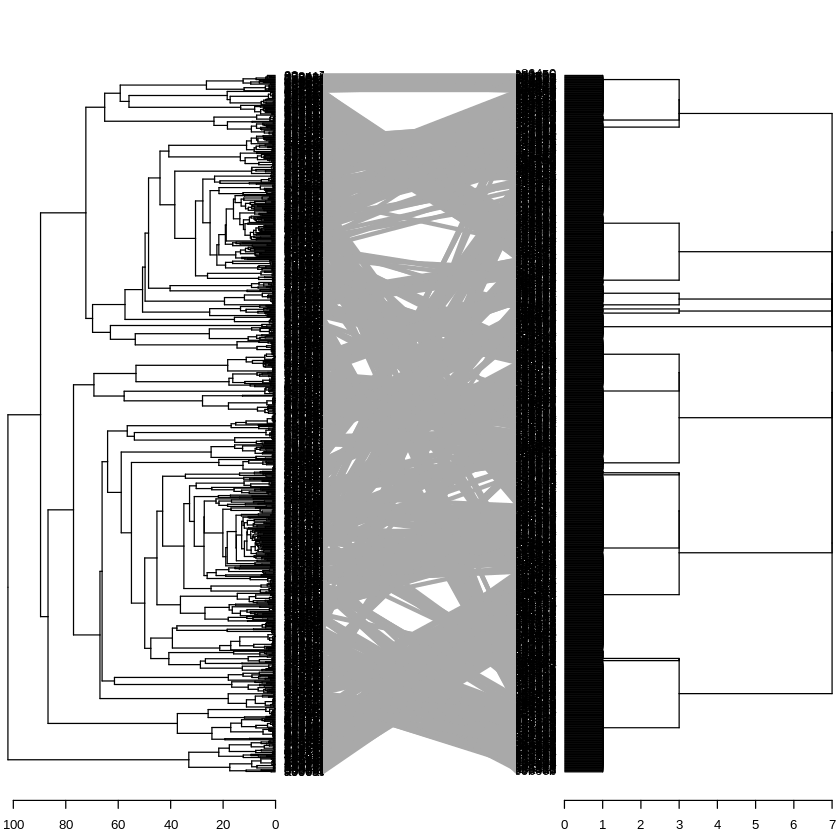

[1] "entanglement: "
[1] 0.2270549


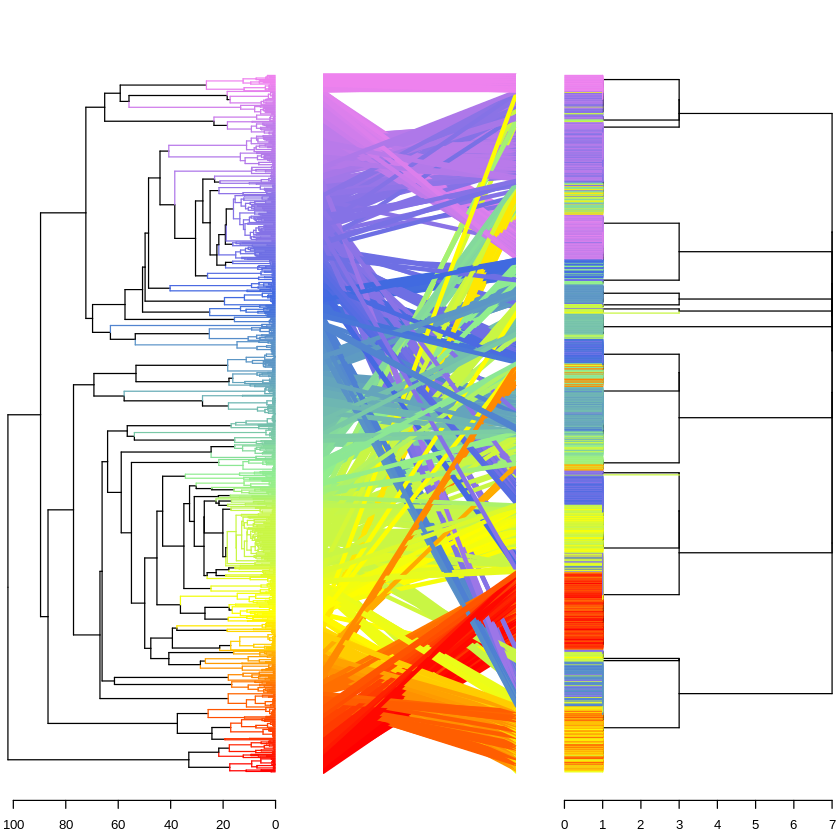

In [8]:
#make tanglegram and untangle to get the best layout 
print('Untangling tanglegram...')
untangle_dends <- untangle(dendlist(as.dendrogram(bacil_euclid_ward),as.dendrogram(ontology_di)), method = 'step2side')
d_untangle <- tanglegram(untangle_dends, common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, sort = FALSE, highlight_branches_lwd=FALSE, faster = TRUE)
hierachy <- untangle_dends[[1]]
subsystems <- untangle_dends[[2]]

#colours to pick from 
print('Generating colours...')
#first tanglegram 
n <- 120 #number of clusters to use to divide the hierachy 
colfunc<-colorRampPalette(c("red","yellow","lightgreen","royalblue", 'violet'))
col_n=(colfunc(n))

# Custom these dendrograms, and place them in a list
hierachy <- hierachy %>% 
    set("labels_col", value = '#FFFFFF', k=n) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = col_n, k = n)

#get the hierachy labels and colours 
hierachy_labels <- labels(hierachy)
hierachy_colours <- get_leaves_branches_col(hierachy)

#make a vector of white colours to colour the labels in the dendrogram (this is the easiet way to remove the labels)
white_col <- replicate(length(hierachy_labels), '#FFFFFF') 

#make the dictionary 
hierachy_dict <- hash(hierachy_labels, hierachy_colours)

#get the subsystems labels 
subsystems_labels <- labels(subsystems)

#generate the subsystem colours 
subsystems_colours <- integer(length(subsystems_labels))

for (i in 1:length(subsystems_labels)){
    
    subsystems_colours[i] <- hierachy_dict[[subsystems_labels[[i]]]]
}


print('Plotting tanglegram...')
dl <- dendlist(
  hierachy,
  subsystems %>% 
    set("branches_k_color", value = subsystems_colours, k = length(subsystems_colours)) %>%
     set("labels_col", value = '#FFFFFF', k=n)
)

tanglegram(dl, 
           common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, sort = FALSE, color_lines = get_leaves_branches_col(hierachy), highlight_branches_lwd=FALSE, faster = TRUE
)

print('entanglement: ')
print(entanglement(dl))